import emcee
%matplotlib inline
import numpy as np
import pylab as mplot
from pylab import cm
import seaborn as sns
sns.set_style("whitegrid")
#import triangle
import scipy.optimize as op
import sys
sys.path.insert(0, './py_scripts')
from splashback_utils import *
from scipy import stats

# Read in data

In [2]:
data = np.load('./chihway_examples/splashback_cov_l20_100_fiducial_bin20.npz')
# data = np.load('~/Dropbox/Work/splashback/cc_measurements/splashback_cov_lgt20.npz')

print(data.files)
sigmag = data['sg_mean']
sigmag_sig = data['sg_sig']
sigmag_cov = data['cov']
rperp = data['r_data'] 

# data = np.load('/Users/chihwaychang/Dropbox/Work/splashback/cc_measurements/splashback_crosscheck_lgt20_more_magcut_nophotoz.npz')
# sigmag = data['sigmag']
# sigmag_sig = data['sigmag_sig']
# sigmag_cov = data['cov']
# rperp = data['R'] 

['mean_z', 'r_data', 'h', 'cov', 'cat', 'mean_lambda', 'sg_mean', 'Sigmag_unit', 'mean_rlambda_com', 'sg_sig', 'DeltaSigma_unit', 'n_clust', 'R_unit', 'mean_rlambda']


In [3]:
print(sigmag_sig)

[0.39660759 0.28342275 0.16668525 0.15499785 0.11400119 0.07910811
 0.05374297 0.05169852 0.04164528 0.03433685 0.02946148 0.0255081
 0.0262506  0.02344196 0.02478703 0.02241805 0.02043558 0.01907874
 0.01712054 0.01484923]


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in log
  # This is added back by InteractiveShellApp.init_path()


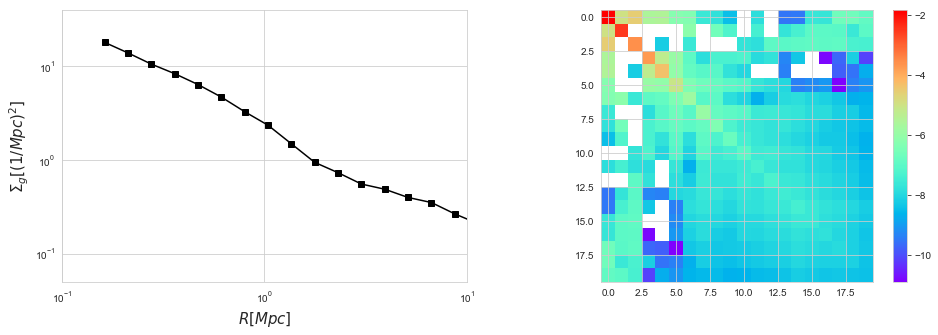

In [4]:
mplot.figure(figsize=(16,5))
mplot.subplot(121)
mplot.errorbar(rperp, sigmag, yerr=sigmag_sig, color='k', marker='s')
mplot.xlabel('$R [Mpc]$', fontsize=15)
mplot.ylabel('$\Sigma_{g} [(1/Mpc)^2]$', fontsize=15)
mplot.xscale('log')
mplot.yscale('log')
mplot.ylim(0.05,40)
mplot.xlim(0.1,10)
mplot.subplot(122)
mplot.imshow(np.log(sigmag_cov), cmap=cm.rainbow)
mplot.colorbar()

# Set initial parameters

In [5]:
h0 = 0.7
z_max = 40./h0
minz_to_integrate = 0.0
maxz_to_integrate = z_max
num_z_tointegrate = 500
z = np.linspace(minz_to_integrate, maxz_to_integrate, num = num_z_tointegrate)

# this is always fixed!
r_o = 1.5/h0

# ML fit (w splashback)

In [6]:
# splashback

log_alpha = -0.32085983 -0.1
log_beta = 0.16309539
log_gamma = 0.64815634
log_r_s = 0.85387196 -0.1
log_r_t = 0.08325509 
log_rho_0 = -0.8865869 -0.5
log_rho_s = -0.19838697 -0.3
se = 1.3290722

# alpha, beta, gamma, r_s, r_t, rho_0, rho_s, se
params = np.array([log_alpha, log_beta, log_gamma, log_r_s, log_r_t, log_rho_0, log_rho_s, se])
lin_params = np.array([10**log_alpha, 10**log_beta, 10**log_gamma, 10**log_r_s, 10**log_r_t, 10**log_rho_0, 10**log_rho_s, se])

In [7]:
#Best model with splashback feature
nll = lambda *args: -1*lnlikelihood(*args)

p0 = params.copy()
bounds = ((None, None), (None,None), (None,None), (np.log10(0.1/h0), np.log10(5.0/h0)), (np.log10(0.1/h0), np.log10(5.0/h0)), (None,None), (None,None), (-10., 10.))
data_vec = sigmag.copy()
invcov = np.linalg.inv(sigmag_cov.copy())
result = op.minimize(nll, p0, args=(rperp, z, data_vec, invcov, h0, 1), options = {'maxiter':200}, bounds = bounds)
best_params = result.x
best_lnlike = -result.fun

print(result)
print(best_lnlike)

      fun: -35.66956048421907
 hess_inv: <8x8 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.00051088,  0.00155822, -0.00192912,  0.01408296,  0.00635296,
        0.0076497 ,  0.00675584, -0.0012939 ])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 1422
      nit: 125
   status: 0
  success: True
        x: array([-1.18617562,  0.75892057,  0.85074217, -0.40677241,  0.22162905,
       -1.10216009,  0.74125204,  1.59899471])
35.66956048421907


# ML fit (w/o splashback)

In [8]:
# this is good for no splsh
log_alpha = -0.32085983 +0.5
log_r_s = 0.85387196 -1
log_rho_0 = -0.8865869 -1.3 
log_rho_s = -0.19838697 +0.6
se = 1.3290722 -1

# alpha, r_s, rho_0, rho_s, se
params_nosplash = np.array([log_alpha, log_r_s, log_rho_0, log_rho_s, se])
lin_params_nosplash = np.array([10**log_alpha, 10**log_r_s, 10**log_rho_0, 10**log_rho_s, se])

In [9]:
#Best model with no splashback feature
nll_nosplash = lambda *args: -1*lnlikelihood(*args)
p0_nosplash = params_nosplash.copy()
bounds_nosplash = ((None,None), (np.log10(0.1/h0), np.log10(5.0/h0)), (None,None), (None, None), (-10., 10.))
data_vec = sigmag.copy()
invcov = np.linalg.inv(sigmag_cov.copy())
result_nosplash = op.minimize(nll_nosplash, p0_nosplash, args=(rperp, z, data_vec, invcov, h0, 0), bounds = bounds_nosplash)

best_params_nosplash = result_nosplash.x
best_lnlike_nosplash = -result_nosplash.fun

print(result_nosplash)
print(best_lnlike_nosplash)

      fun: 0.4471491966875333
 hess_inv: <5x5 LbfgsInvHessProduct with dtype=float64>
      jac: array([-2.45503617e-04,  5.15854026e-04,  2.75690581e-04,  2.58637556e-04,
       -6.53699317e-05])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 270
      nit: 38
   status: 0
  success: True
        x: array([-0.33003313, -0.33705537, -1.14879468,  0.65106223,  1.58241831])
-0.4471491966875333


# Plot all this

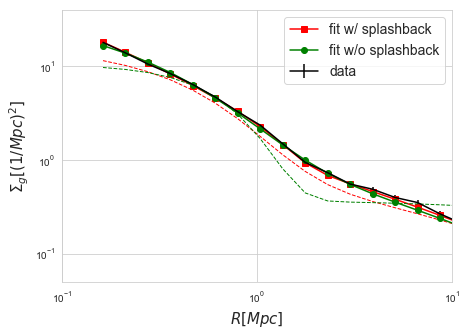

In [13]:
mplot.figure(figsize=(7,5))

mplot.errorbar(rperp, sigmag, yerr=sigmag_sig, label='data', color='k')
mplot.semilogx(rperp, Sigmag(rperp, z, p0, h0, 1), color='r', ls='--', lw=1)
mplot.semilogx(rperp, Sigmag(rperp, z, best_params, h0, 1), label='fit w/ splashback', color='r', marker='s')
mplot.semilogx(rperp, Sigmag(rperp, z, p0_nosplash, h0, 0), color='g', ls='--', lw=1)
mplot.semilogx(rperp, Sigmag(rperp, z, best_params_nosplash, h0, 0), label='fit w/o splashback', color='g', marker='o')

mplot.xlabel('$R [Mpc]$', fontsize=15)
mplot.ylabel('$\Sigma_{g} [(1/Mpc)^2]$', fontsize=15)
mplot.xscale('log')
mplot.yscale('log')
mplot.ylim(0.05,40)
mplot.xlim(0.1,10)

mplot.legend(fontsize=14)


mplot.savefig('/Users/arielamsellem/Desktop/Mean_Sigmag_orig.png', dpi = 600)


# Look at log derivative

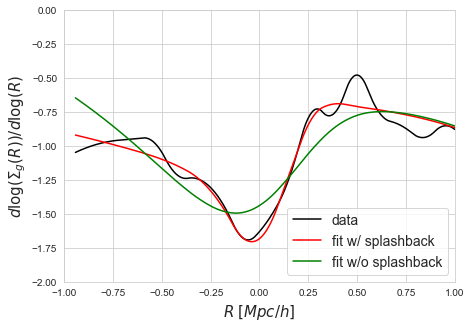

In [12]:
mplot.figure(figsize=(7,5))
ax = mplot.subplot(111)

r1, dsdr1 = derivative_savgol(rperp, sigmag, N=10000, window_length=5, polyorder=3)
r2, dsdr2 = derivative_savgol(rperp, Sigmag(rperp, z, best_params, h0, 1), N=10000, window_length=5, polyorder=3)
r3, dsdr3 = derivative_savgol(rperp, Sigmag(rperp, z, best_params_nosplash, h0, 0), N=10000, window_length=5, polyorder=3)

mplot.plot(r1+np.log10(h0), dsdr1, color='k', label='data')
mplot.plot(r2+np.log10(h0), dsdr2, color='r', label='fit w/ splashback')
mplot.plot(r3+np.log10(h0), dsdr3, color='g', label='fit w/o splashback')
#ax.fill_between(data['r2']+np.log10(h0), np.log10(10**(data['dlnsg_mean_sm']-data['dlnsg_std_sm'])), 
#                 np.log10(10**(data['dlnsg_mean_sm']+data['dlnsg_std_sm'])), facecolor='k', 
#                 edgecolor='white', alpha=0.2, interpolate=True)

mplot.ylim(-2,0)
mplot.xlim(-1,1)
mplot.legend(fontsize=14, loc='lower right')
mplot.ylabel('$d\log(\Sigma_{g}(R))/d\log(R)$', fontsize=15)
mplot.xlabel('$R \;[Mpc/h]$', fontsize=15)

mplot.savefig('/Users/arielamsellem/Desktop/Mean_Sigmag_deriv_orig.png', dpi = 600)

# Likelihood ratio test

In [ ]:
bigD = 2.*(best_lnlike - best_lnlike_nosplash)
df = len(best_params) - len(best_params_nosplash)
prob = 1 - stats.chi2.cdf(bigD, df)
zscore = stats.norm.ppf(1-prob/2.0)

print(best_lnlike, best_lnlike_nosplash, prob, zscore)

In [ ]:
print(stats.chi2.cdf(bigD, df))

In [ ]:
# new data lgt20
# 45.8004562662 8.71600506227 5.55111512313e-16 8.1258906647
# new data l10_20
# 41.2032328262 -1.5571077401 0.0 inf
# old data lgt20
# 37.7170860377 -56.3869397597 0.0 inf

# consider using less points for the fit?!

# Now consider lensing...

In [ ]:
data = np.loadtxt('/Users/chihwaychang/Dropbox/Work/splashback/cs_measurements/test_l10_20_comoving_deltasigma', comments='#')
# print data.files
sigma = data[:,1]*h0**2
sigma_sig = data[:,2]*h0**2
rperp = data[:,0]/h0 
sigma_cov = np.loadtxt('/Users/chihwaychang/Dropbox/Work/splashback/cs_measurements/test_l10_20_comoving_cov')*h0**4

In [ ]:
# splashback

log_alpha = -0.32085983 -2
log_beta = 0.16309539 +0.1
log_gamma = 0.64815634 +0.1
log_r_s = -0.1 #0.85387196 -0.7
log_r_t = 0.0 # 0.08325509 +0.4
log_rho_0 = -0.8865869 +0.3
log_rho_s = -0.19838697 +1
se = 1.3290722 -0.2

# alpha, beta, gamma, r_s, r_t, rho_0, rho_s, se
params = np.array([log_alpha, log_beta, log_gamma, log_r_s, log_r_t, log_rho_0, log_rho_s, se])
lin_params = np.array([10**log_alpha, 10**log_beta, 10**log_gamma, 10**log_r_s, 10**log_r_t, 10**log_rho_0, 10**log_rho_s, se])

In [ ]:
mplot.figure(figsize=(16,5))
mplot.subplot(121)
mplot.errorbar(rperp, sigma, yerr=sigma_sig, color='k', marker='s')
mplot.plot(rperp, DSigmag(rperp, z, params, h0, 1), label='fit', color='g', marker='s')
mplot.xlabel('$R [Mpc/h]$', fontsize=15)
mplot.ylabel('$\Delta \Sigma [(h/Mpc)^2]$', fontsize=15)
mplot.xscale('log')
mplot.yscale('log')
# mplot.ylim(0.1,100)
# mplot.xlim(0.1,10)
mplot.subplot(122)
mplot.imshow(np.log(sigmag_cov), cmap=cm.rainbow)
mplot.colorbar()


# assume these are with h's

In [ ]:
r1, dsdr1 = derivative_savgol(rperp[1:-1], DSigmag(rperp, z, params, h0, 1)[1:-1], N=10000, window_length=5, polyorder=3)
mplot.plot(r1,dsdr1)
mplot.ylim(-2,0)

# ML fit w/splashback

In [ ]:
# splashback

log_alpha = -0.32085983 -2
log_beta = 0.16309539 +0.1
log_gamma = 0.64815634 +0.1
log_r_s = -0.1 #0.85387196 -0.7
log_r_t = 0.0 # 0.08325509 +0.4
log_rho_0 = -0.8865869 +0.3
log_rho_s = -0.19838697 +1
se = 1.3290722 -0.2

# alpha, beta, gamma, r_s, r_t, rho_0, rho_s, se
params = np.array([log_alpha, log_beta, log_gamma, log_r_s, log_r_t, log_rho_0, log_rho_s, se])
lin_params = np.array([10**log_alpha, 10**log_beta, 10**log_gamma, 10**log_r_s, 10**log_r_t, 10**log_rho_0, 10**log_rho_s, se])

In [ ]:
#Best model with splashback feature
nll = lambda *args: -1*lnlikelihoodD(*args)

p0 = params.copy()
bounds = ((None, None), (None,None), (None,None), (np.log10(0.1/h0), np.log10(5.0/h0)), (np.log10(0.1/h0), np.log10(5.0/h0)), (None,None), (None,None), (-10., 10.))
data_vec = sigma[1:-1].copy()
invcov = np.linalg.inv(sigma_cov[1:-1, 1:-1].copy())
result = op.minimize(nll, p0, args=(rperp[1:-1], z, data_vec, invcov, h0, 1), options = {'maxiter':200}, bounds = bounds)
best_params = result.x
best_lnlike = -result.fun

print result
print best_lnlike
print best_params

# ML fit w/o splashback

In [ ]:
# this is good for no splsh
log_alpha = -0.32085983 - 0.7
log_r_s = 0.85387196 -1.2
log_rho_0 = -0.8865869 -0.8
log_rho_s = -0.19838697 +1.4
se = 1.3290722 

# alpha, r_s, rho_0, rho_s, se
params_nosplash = np.array([log_alpha, log_r_s, log_rho_0, log_rho_s, se])
lin_params_nosplash = np.array([10**log_alpha, 10**log_r_s, 10**log_rho_0, 10**log_rho_s, se])

In [ ]:
#Best model with no splashback feature
nll_nosplash = lambda *args: -1*lnlikelihoodD(*args)
p0_nosplash = params_nosplash.copy()

bounds_nosplash = ((None,None), (np.log10(0.1/h0), np.log10(5.0/h0)), (None,None), (None, None), (-10., 10.))
data_vec = sigma[1:-1].copy()
invcov = np.linalg.inv(sigma_cov[1:-1,1:-1].copy())
result_nosplash = op.minimize(nll_nosplash, p0_nosplash, args=(rperp[1:-1], z, data_vec, invcov, h0, 0), bounds = bounds_nosplash)

best_params_nosplash = result_nosplash.x
best_lnlike_nosplash = -result_nosplash.fun

print result_nosplash
print best_lnlike_nosplash

# Plot all of this

In [ ]:
mplot.figure(figsize=(7,5))

mplot.errorbar(rperp, sigma, yerr=sigma_sig, label='data', color='k')
mplot.semilogx(rperp[1:-1], DSigmag(rperp, z, p0, h0, 1)[1:-1], color='r', ls='--', lw=1)
mplot.semilogx(rperp[1:-1], DSigmag(rperp, z, best_params, h0, 1)[1:-1], label='fit w/ splashback', color='r', marker='s')
mplot.semilogx(rperp[1:-1], DSigmag(rperp, z, p0_nosplash, h0, 0)[1:-1], color='g', ls='--', lw=1)
mplot.semilogx(rperp[1:-1], DSigmag(rperp, z, best_params_nosplash, h0, 0)[1:-1], label='fit w/o splashback', color='g', marker='o')

mplot.xlabel('$R [Mpc]$', fontsize=15)
mplot.ylabel('$\Sigma_{g} [(1/Mpc)^2]$', fontsize=15)
mplot.xscale('log')
mplot.yscale('log')
mplot.ylim(0.1,100)
mplot.xlim(0.1,10)

mplot.legend(fontsize=14)

In [ ]:
mplot.figure(figsize=(7,5))
ax = mplot.subplot(111)

r1, dsdr1 = derivative_savgol(rperp, sigma, N=10000, window_length=5, polyorder=3)
r2, dsdr2 = derivative_savgol(rperp[1:-1], DSigmag(rperp, z, best_params, h0, 1)[1:-1], N=10000, window_length=5, polyorder=3)
r3, dsdr3 = derivative_savgol(rperp[1:-1], DSigmag(rperp, z, best_params_nosplash, h0, 0)[1:-1], N=10000, window_length=5, polyorder=3)

print DSigmag(rperp[1:-1], z, best_params_nosplash, h0, 0)
print dsdr2
mplot.plot(r1+np.log10(h0), dsdr1, color='k', label='data')
mplot.plot(r2+np.log10(h0), dsdr2, color='r', label='fit w/ splashback')
mplot.plot(r3+np.log10(h0), dsdr3, color='g', label='fit w/o splashback')

mplot.ylim(-2.5,0)
mplot.xlim(-1,1)
mplot.legend(fontsize=14, loc='lower left')
mplot.ylabel('$d\log(\Sigma_{g}(R))/d\log(R)$', fontsize=15)
mplot.xlabel('$R \;[Mpc/h]$', fontsize=15)

